In [ ]:
!pip install mediapipe

In [ ]:
import os
import io
import zipfile
import shutil 
from pathlib import Path
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Функция для распаковки zip-архива
def unzip_data(zip_file, destination_dir):
    print('Data extraction started...', end='')
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print('done.')
    print(f'Files unzipped to \'{destination_dir}\'\n')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root = '/content/ck48/'
unzip_data(zip_file='/content/drive/MyDrive/ck48-mini.zip', destination_dir='/content/ck48-mini/source/')

Data extraction started...done.
Files unzipped to '/content/ck48-mini/source/'



In [ ]:
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
train_dir = 'train'
valid_dir = 'valid'

In [ ]:
for root, dirs, files in os.walk("/content/ck48-mini/source/"):
    if not files:
        continue
    prefix = os.path.basename(root)
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f)))

In [ ]:
!mkdir /content/ck48-mini/train/

In [ ]:
for root, dirs, files in os.walk('/content/ck48-mini/source/'):
   for file in files:
      path_file = os.path.join(root,file)
      shutil.copy2(path_file, '/content/ck48-mini/train/')

In [ ]:
# инициализируем FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,
                                         min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [ ]:
DATA_DIR = '/content/ck48-mini/train/'

In [ ]:
def create_probe_eval_set(files: List):
    # выбираем случайный индекс между 0 и len(files)-1
    random_idx = np.random.randint(0,len(files))
    probe_img_fpaths = [files[random_idx]]
    eval_img_fpaths = [files[idx] for idx in range(len(files)) if idx != random_idx]
    return probe_img_fpaths, eval_img_fpaths

In [ ]:
def get_facemesh_coords(landmark_list, img):
    # преобразуем FaceMesh landmarks координаты в 468x3 NumPy массив.
    h, w = img.shape[:2]
    xyz = [(lm.x, lm.y, lm.z) for lm in landmark_list.landmark]
    res = np.multiply(xyz, [w, h, w]).astype(int)
    return res

In [ ]:
# генерируем face landmarks
def generate_face_landmarks(img_fpaths: List[str]):
    landmarks_set = list()
    landmarks_label = list()

    for img_fpath in img_fpaths:
        f = os.path.join(DATA_DIR, img_fpath)
        img = cv2.imread(f)
        # добавляем face landmarks
        results = face_mesh_images.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))       
        landmarks_set.append(get_facemesh_coords(results.multi_face_landmarks[0], img))
        # добавляем метки классов
        landmarks_label.append(img_fpath.split("_")[0])   

    return landmarks_set, landmarks_label

In [ ]:
files = os.listdir(DATA_DIR)
files.sort()
eval_set = list()
eval_labels = list()
probe_set = list()
probe_labels = list()
IMAGES_PER_IDENTITY = 49
for i in tqdm(range(0, len(files), IMAGES_PER_IDENTITY), unit_divisor=True):
    probe, eval = create_probe_eval_set(files[i:i+IMAGES_PER_IDENTITY])
    # Генерируем face_landmarks:
    eval_set_t, eval_labels_t = generate_face_landmarks(eval)
    eval_set.extend(eval_set_t)
    eval_labels.extend(eval_labels_t)
    
    probe_set_t, probe_labels_t = generate_face_landmarks(probe)
    probe_set.extend(probe_set_t)
    probe_labels.extend(probe_labels_t)

100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


In [ ]:
eval_set2d = list()
for eval in eval_set:
  eval1d = eval.reshape((1404, ))
  eval_set2d.append(eval1d)
arrX = np.array(eval_set2d) 

In [ ]:
probe_set2d = list()
for probe in probe_set:
  probe1d = probe.reshape((1404, ))
  probe_set2d.append(probe1d)
arrY = np.array(probe_set2d) 

In [ ]:
# Для распознавания будем использовать классификатор kNN с метрикой расстояния 'cosine'
nn = NearestNeighbors(n_neighbors=3, metric="cosine")
nn.fit(X=arrX)

NearestNeighbors(metric='cosine', n_neighbors=3)

In [ ]:
dists, inds = nn.kneighbors(X=arrY, n_neighbors=2, return_distance=True)

In [ ]:
# Посчитаем метрику p@k (Precision@K)
p_at_k = np.zeros(len(arrY))
for i in range(len(arrY)):
    true_label = probe_labels[i]
    pred_neighbr_idx = inds[i]
    
    pred_labels = [eval_labels[id] for id in pred_neighbr_idx]
    pred_is_labels = [1 if label == true_label else 0 for label in pred_labels]
    
    p_at_k[i] = np.mean(pred_is_labels)
    
p_at_k.mean()

0.9285714285714286

In [ ]:
# Инференс модели
def print_ID_results(img_fpath: str, evaluation_labels: np.ndarray, verbose: bool = False):

    results = face_mesh_images.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    landmarks = get_facemesh_coords(results.multi_face_landmarks[0], img)
    landmarks = landmarks.reshape((468*3, ))
    
    # получаем предсказание
    dists, inds = nn.kneighbors(X=landmarks.reshape(1,-1), n_neighbors=1, return_distance=True)

    # получаем метки
    pred_labels = [eval_labels[i] for i in inds[0]]

    no_of_matching_emotions = np.sum([1 if d <=0.6 else 0 for d in dists[0]])
    if no_of_matching_emotions > 0:
        print("Matching emotion found in database! ")
        verbose = True
    else: 
        print("No matching emotion not found in database!")
        
    # выводим метки и соответствуюие расстояния
    if verbose:
        for label, dist in zip(pred_labels, dists[0]):
            print(f"Nearest neighbours found in the database have labels {label} and is at a distance of {dist}")

Matching emotion found in database! 
Nearest neighbours found in the database have labels happy and is at a distance of 4.440892098500626e-16


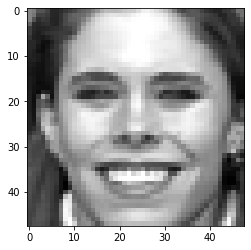

In [ ]:
# Протестируем полученную модель
img = cv2.imread("/content/drive/MyDrive/S032_006_00000015.png")
plt.imshow(img)
print_ID_results("/content/drive/MyDrive/S032_006_00000015.png", eval_labels, verbose=True)

Matching emotion found in database! 
Nearest neighbours found in the database have labels surprise and is at a distance of 0.0007084080807938653


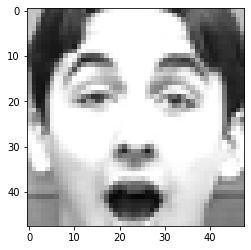

In [ ]:
img = cv2.imread("/content/drive/MyDrive/S037_001_00000019.png")
plt.imshow(img)
print_ID_results("/content/drive/MyDrive/S037_001_00000019.png", eval_labels, verbose=True)

Matching emotion found in database! 
Nearest neighbours found in the database have labels anger and is at a distance of 0.0


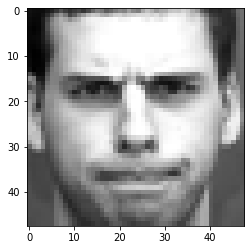

In [ ]:
img = cv2.imread("/content/drive/MyDrive/S058_005_00000008.png")
plt.imshow(img)
print_ID_results("/content/drive/MyDrive/S058_005_00000008.png", eval_labels, verbose=True)

Matching emotion found in database! 
Nearest neighbours found in the database have labels fear and is at a distance of 0.0003657310656240975


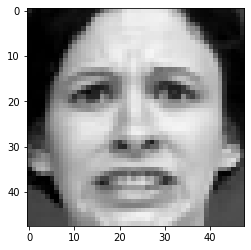

In [ ]:
img = cv2.imread("/content/drive/MyDrive/S138_001_00000010.png")
plt.imshow(img)
print_ID_results("/content/drive/MyDrive/S138_001_00000010.png", eval_labels, verbose=True)